## Load normalized data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras import models
from keras import layers
import numpy as np

normalized_data = pd.read_csv("normalized_data.csv", index_col=0)
normalized_data

Using TensorFlow backend.


,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,...,SOTON/O.Q.,2.,W./C.,STON/O,CA.,A/5,SC/PARIS,2343,CA,A/5.
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.271174,0.2,0.000000,0.014151,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.472229,0.2,0.000000,0.139136,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.321438,0.0,0.000000,0.015469,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.434531,0.2,0.000000,0.103644,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.434531,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,1.0,NaN,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1306,NaN,0.0,0.484795,0.0,0.000000,0.212559,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,NaN,1.0,0.478512,0.0,0.000000,0.014151,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Counting empty values

In [2]:
empty_values = [(label, normalized_data[label].isnull().sum()) for label in normalized_data.columns.values]
sorted(empty_values, reverse=True, key=lambda tup: tup[1])

[('Survived', 418),
 ('Age', 263),
 ('Pclass', 0),
 ('SibSp', 0),
 ('Parch', 0),
 ('Fare', 0),
 ('female', 0),
 ('male', 0),
 ('C', 0),
 ('Q', 0),
 ('S', 0),
 ('Mr', 0),
 ('Miss', 0),
 ('Mrs', 0),
 ('PC', 0),
 ('C.A.', 0),
 ('SOTON/O.Q.', 0),
 ('2.', 0),
 ('W./C.', 0),
 ('STON/O', 0),
 ('CA.', 0),
 ('A/5', 0),
 ('SC/PARIS', 0),
 ('2343', 0),
 ('CA', 0),
 ('A/5.', 0)]

## Separate samples with and without age

In [3]:
samples_with_age = normalized_data[normalized_data.Age.notna()]
samples_without_age = normalized_data[normalized_data.Age.isna()]

## Creating model for age prediction

In [4]:
x_train_age = samples_with_age.drop(["Age", "Survived"], axis=1).values
y_train_age = samples_with_age["Age"].values

number_of_epochs = 25
number_of_folds = 5
number_of_samples = len(x_train_age) // number_of_folds

all_mae_histories = []
all_val_mae_histories = []
for i in range(number_of_folds):
    partial_x_train_age = np.concatenate([x_train_age[:i*number_of_samples], x_train_age[(i+1)*number_of_samples:]])
    parital_y_train_age = np.concatenate([y_train_age[:i*number_of_samples], y_train_age[(i+1)*number_of_samples:]])
    
    partial_x_validation_age = x_train_age[i*number_of_samples:(i+1)*number_of_samples]
    partial_y_validation_age = y_train_age[i*number_of_samples:(i+1)*number_of_samples]

    model = models.Sequential()
    model.add(layers.Dense(x_train_age.shape[1], activation="relu", input_shape=(x_train_age.shape[1],)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1))

    model.compile(optimizer="rmsprop",
                  loss="mse",
                  metrics=["mae"])

    history = model.fit(partial_x_train_age,
                        parital_y_train_age,
                        epochs=number_of_epochs,
                        batch_size=16,
                        validation_data=(partial_x_validation_age, partial_y_validation_age))
    all_mae_histories.append(history.history['val_mae'])
    all_val_mae_histories.append(history.history['mae'])


Train on 837 samples, validate on 209 samples
Epoch 1/25
837/837 [==============================] - 0s 361us/step - loss: 0.1148 - mae: 0.2705 - val_loss: 0.0392 - val_mae: 0.1483
Epoch 2/25
837/837 [==============================] - 0s 140us/step - loss: 0.0687 - mae: 0.2055 - val_loss: 0.0363 - val_mae: 0.1441
Epoch 3/25
837/837 [==============================] - 0s 148us/step - loss: 0.0518 - mae: 0.1816 - val_loss: 0.0355 - val_mae: 0.1437
Epoch 4/25
837/837 [==============================] - 0s 156us/step - loss: 0.0422 - mae: 0.1608 - val_loss: 0.0323 - val_mae: 0.1364
Epoch 5/25
837/837 [==============================] - 0s 135us/step - loss: 0.0365 - mae: 0.1499 - val_loss: 0.0314 - val_mae: 0.1347
Epoch 6/25
837/837 [==============================] - 0s 124us/step - loss: 0.0352 - mae: 0.1451 - val_loss: 0.0282 - val_mae: 0.1283
Epoch 7/25
837/837 [==============================] - 0s 154us/step - loss: 0.0331 - mae: 0.1407 - val_loss: 0.0280 - val_mae: 0.1274
Epoch 8/25
837/8

Epoch 11/25
837/837 [==============================] - 0s 128us/step - loss: 0.0293 - mae: 0.1319 - val_loss: 0.0324 - val_mae: 0.1359
Epoch 12/25
837/837 [==============================] - 0s 136us/step - loss: 0.0289 - mae: 0.1309 - val_loss: 0.0308 - val_mae: 0.1337
Epoch 13/25
837/837 [==============================] - 0s 122us/step - loss: 0.0287 - mae: 0.1304 - val_loss: 0.0319 - val_mae: 0.1351
Epoch 14/25
837/837 [==============================] - 0s 120us/step - loss: 0.0275 - mae: 0.1285 - val_loss: 0.0324 - val_mae: 0.1356
Epoch 15/25
837/837 [==============================] - 0s 136us/step - loss: 0.0283 - mae: 0.1315 - val_loss: 0.0325 - val_mae: 0.1353
Epoch 16/25
837/837 [==============================] - 0s 131us/step - loss: 0.0282 - mae: 0.1305 - val_loss: 0.0309 - val_mae: 0.1334
Epoch 17/25
837/837 [==============================] - 0s 131us/step - loss: 0.0260 - mae: 0.1236 - val_loss: 0.0325 - val_mae: 0.1355
Epoch 18/25
837/837 [==============================] - 

837/837 [==============================] - 0s 139us/step - loss: 0.0250 - mae: 0.1251 - val_loss: 0.0208 - val_mae: 0.1181
Epoch 22/25
837/837 [==============================] - 0s 152us/step - loss: 0.0252 - mae: 0.1228 - val_loss: 0.0214 - val_mae: 0.1176
Epoch 23/25
837/837 [==============================] - 0s 146us/step - loss: 0.0260 - mae: 0.1251 - val_loss: 0.0215 - val_mae: 0.1186
Epoch 24/25
837/837 [==============================] - 0s 136us/step - loss: 0.0243 - mae: 0.1214 - val_loss: 0.0205 - val_mae: 0.1179
Epoch 25/25
837/837 [==============================] - 0s 139us/step - loss: 0.0265 - mae: 0.1256 - val_loss: 0.0210 - val_mae: 0.1193


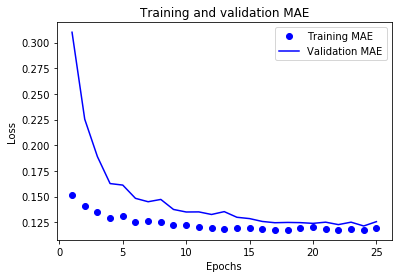

In [5]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(number_of_epochs)]
average_val_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(number_of_epochs)]

epochs = range(1, number_of_epochs + 1)

plt.plot(epochs, all_mae_histories[i], "bo", label="Training MAE")
plt.plot(epochs, all_val_mae_histories[i], "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Evaluate results for age prediction

In [6]:
results_age = model.predict(samples_without_age.drop(["Survived", "Age"], axis=1))
samples_without_age.loc[:,"Age"] = results_age
samples_without_age

/home/victor/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,...,SOTON/O.Q.,2.,W./C.,STON/O,CA.,A/5,SC/PARIS,2343,CA,A/5.
PassengerId,,,,,,,,,,,,,,,,,,,,,
6,0.0,1.0,0.400498,0.0,0.000000,0.016510,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,1.0,0.5,0.385437,0.0,0.000000,0.025374,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,1.0,1.0,0.342570,0.0,0.000000,0.014102,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,1.0,0.319028,0.0,0.000000,0.014102,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,1.0,1.0,0.285468,0.0,0.000000,0.015379,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,NaN,1.0,0.285462,0.0,0.000000,0.015070,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1302,NaN,1.0,0.285463,0.0,0.000000,0.015127,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1305,NaN,1.0,0.359572,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Save data

In [7]:
normalized_data_with_predicted_age = pd.concat([samples_with_age, samples_without_age])
normalized_data_with_predicted_age.to_csv("normalized_data_with_predicted_age.csv", index=True)
normalized_data_with_predicted_age

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,...,SOTON/O.Q.,2.,W./C.,STON/O,CA.,A/5,SC/PARIS,2343,CA,A/5.
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.271174,0.2,0.000000,0.014151,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.472229,0.2,0.000000,0.139136,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.321438,0.0,0.000000,0.015469,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.434531,0.2,0.000000,0.103644,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.434531,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,NaN,1.0,0.285462,0.0,0.000000,0.015070,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1302,NaN,1.0,0.285463,0.0,0.000000,0.015127,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1305,NaN,1.0,0.359572,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Compare skewness of original and predicted Age

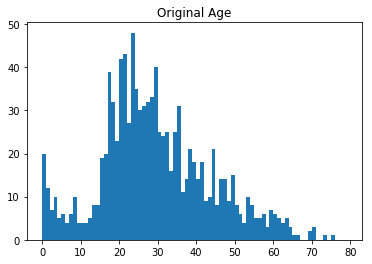

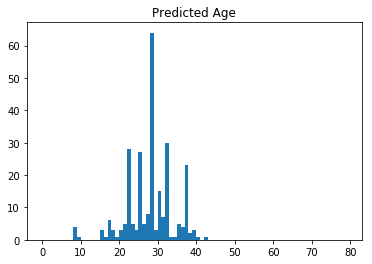

In [8]:
import matplotlib.pyplot as plt
scalar = 80

plt.hist(samples_with_age.Age*scalar, range(scalar))
plt.title("Original Age")
plt.show()

plt.hist(results_age*scalar, range(scalar))
plt.title("Predicted Age")
plt.show()